<a href="https://colab.research.google.com/github/RealMyeong/NLP_kaggle_transcription/blob/main/Simple_Feature_Engg_Notebook_Spooky_Author_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Feature Engg Notebook 필사

[참고 노트북](https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook)

이번 대회의 목적:

이번 대회의 데이터셋은 공포 소설 작가들이 public domain에 작성한 소설의 텍스트로 구성되어 있습니다.

도메인 종류
1. Edgar Allan Poe(EAP)
2. HP Lovecraft(HPL)
3. Mary Wollstonecraft Shelley(MWS)

노트북의 목적:

이 노트북에서, 작가들을 구분하는데 도움을 줄 수 있는 새로운 feature를 만들어 보겠습니다.

feature engineering 부분을 깊게 파기전에 먼저 간단한 데이터 시각화와 정제작업을 진행하겠습니다.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


```
# SettingWithCopyError --> 오류 raise 로 코드 실행 X
pd.set_option('mode.chained_assignment', 'raise') 

# SettingWithCopyWarning --> 실행은 되지만 경고문 뜸
pd.set_option('mode.chained_assignment', 'warn') 

# error, warning 무시 --> 경고 끔
pd.set_option('mode.chained_assignment',  None) 
```

In [3]:
# Read the train and test dataset and check the top few lines 
train_df = pd.read_csv('/content/drive/MyDrive/AIFFEL/NLP_캐글필사/Simple_Feature_Engg_Notebook/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AIFFEL/NLP_캐글필사/Simple_Feature_Engg_Notebook/test.csv')
print("Number of rows in train dataset : ", train_df.shape[0])
print("Number of rows in test dataset : ", test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


작가별 데이터수를 보겠습니다.

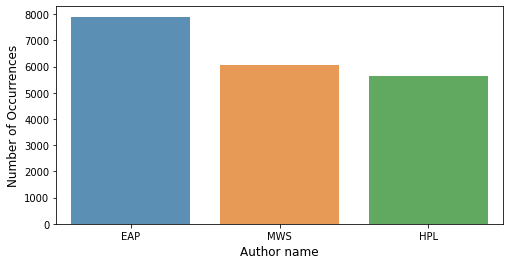

In [7]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel("Author name", fontsize=12)
plt.show()

라벨 불균형이 심하지 않은 것 같습니다. 

작가별 텍스트를 한 번 뽑아서 작가의 스타일을 보겠습니다.

In [8]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
  print("Author name : ", name)
  cnt = 0
  for ind, row in group.iterrows():
    print(row['text'])
    cnt += 1
    if cnt == 5:
      break
  
print('\n')

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

글을 보다보니 텍스트 데이터에 몇몇 특정 글자들이 있는게 보입니다.

이 특정 글자들의 갯수가 아마도 작가의 글에대한 큰 특징이 될 것 같습니다.

### Feature Engineering:

이제 몇 개의 feature engineering을 해보겠습니다. 이 과정에는 2개의 main part가 있습니다.
1. Meta features : 단어의 개수, 불용어의 개수, 구두점의 개수와 같이 텍스트로부터 추출해낸 특징
2. Text based features : 텍스트나 단어와 직접적으로 연관된 특징, 예를 들어 빈도수, SVD, Word2Vec 등등

### Meta Features:
우리는 feature를 만들어보고, 그것들이 작가를 예측하는데 어마나 도움이 되는지 보겠습니다. 만들 feature는 아래와 같습니다.

1. 텍스트에 있는 단어의 수
2. 텍스트에 있는 고유한 단어의 수
3. 텍스트에 있는 문자의 수
4. 불용어의 수
5. 구두점의 수
6. 대문자로 된 단어의 수
7. 제목에 해당하는 단어의 수
8. 단어의 평균 길이


In [18]:
# Number of words in the text
train_df['num_words'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x : len(str(x).split()))

# Number of unique words in the text
train_df['num_unique_words'] = train_df['text'].apply(lambda x : len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x : len(set(str(x).split())))

# Number of characters in the text
train_df['num_chars'] = train_df['text'].apply(lambda x : len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x : len(str(x)))

# Number of stopwords in the text
train_df['num_stopwords'] = train_df['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of punctuations in the text
train_df['num_punctuations'] = train_df['text'].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))

# Number of upper case words in the text
train_df['num_words_upper'] = train_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))

# Number of titme case words in the text
train_df['num_words_title'] = train_df['text'].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the text
train_df['mean_word_len'] = train_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

새롭게 만들어준 feature들을 시각화해서 예측에 도움을 줄 수 있을지 보겠습니다.

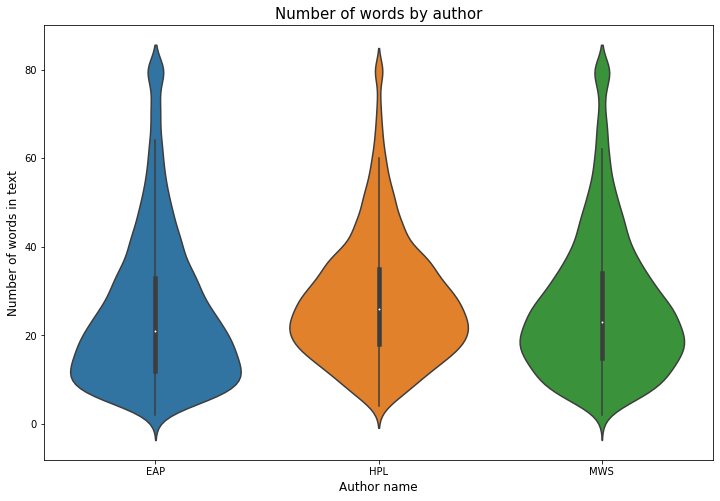

In [19]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 # truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP가 약간 단어의 수가 적은 것 같습니다.

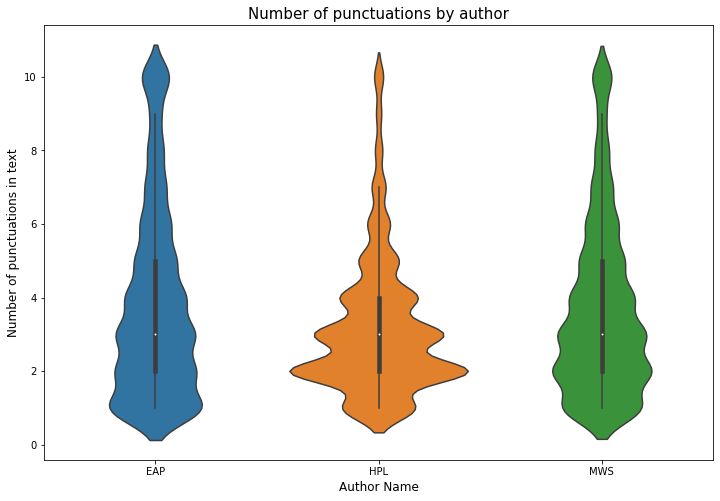

In [20]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title('Number of punctuations by author', fontsize=15)
plt.show()

이것도 어느정도 유용할 것 같습니다.

이제 text based feature를 만들어 보겠습니다.

먼저, 우리가 만든 meta features가 얼마나 도움이 되는지를 볼 수 있는 basic model을 만들겠습니다.

In [21]:
# Prepare the data for modeling
author_mapping_dict = {'EAP' : 0, 'HPL' : 1, 'MWS' : 2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# recompute the truncated variables again
train_df['num_words'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x : len(str(x).split()))
train_df['mean_word_len'] = train_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

XGBoost 모델을 meta features만 이용해서 훈련 해보겠습니다.

In [22]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
  param={}
  param['objective'] = 'multi:softprob'
  param['eta'] = 0.1
  param['max_depth'] = 3
  param['silent'] = 1
  param['num_class'] = 3
  param['eval_metric'] = 'mlogloss'
  param['min_child_weight'] = child
  param['subsample'] = 0.8
  param['colsample_bytree'] = colsample
  param['seed'] = seed_val
  num_rounds = 2000

  plst = list(param.items())
  xgtrain = xgb.DMatrix(train_X, label=train_y)

  if test_y is not None:
    xgtest = xgb.DMatrix(test_X, label=test_y)
    watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
  
  else:
    xgtest = xgb.DMatrix(test_X)
    model = xgb.train(plst, xgtrain, num_rounds)

  pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
  if test_X2 is not None:
    xgtest2 = xgb.DMatrix(test_X2)
    pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
  
  return pred_test_y, pred_test_y2, model

In [23]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.0937	test-mlogloss:1.09453
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04138	test-mlogloss:1.05172
[40]	train-mlogloss:1.02343	test-mlogloss:1.03983
[60]	train-mlogloss:1.01043	test-mlogloss:1.03051
[80]	train-mlogloss:1.00001	test-mlogloss:1.02301
[100]	train-mlogloss:0.992056	test-mlogloss:1.01754
[120]	train-mlogloss:0.983985	test-mlogloss:1.01192
[140]	train-mlogloss:0.977474	test-mlogloss:1.00829
[160]	train-mlogloss:0.972334	test-mlogloss:1.00502
[180]	train-mlogloss:0.967121	test-mlogloss:1.00192
[200]	train-mlogloss:0.962841	test-mlogloss:1.00031
[220]	train-mlogloss:0.959004	test-mlogloss:0.999193
[240]	train-mlogloss:0.954595	test-mlogloss:0.997093
[260]	train-mlogloss:0.951285	test-mlogloss:0.99559
[280]	train-mlogloss:0.94809	test-mlogloss:0.994533
[300]	train-mlogloss:0.945068	test-mlogloss:0.993919
[320]	train-mlogloss:0.942

 0.989 의 mlogloss를 얻었습니다. 나쁘지 않은 점수입니다.

 feature 중요도도 한 번 뽑아보겠습니다.
 

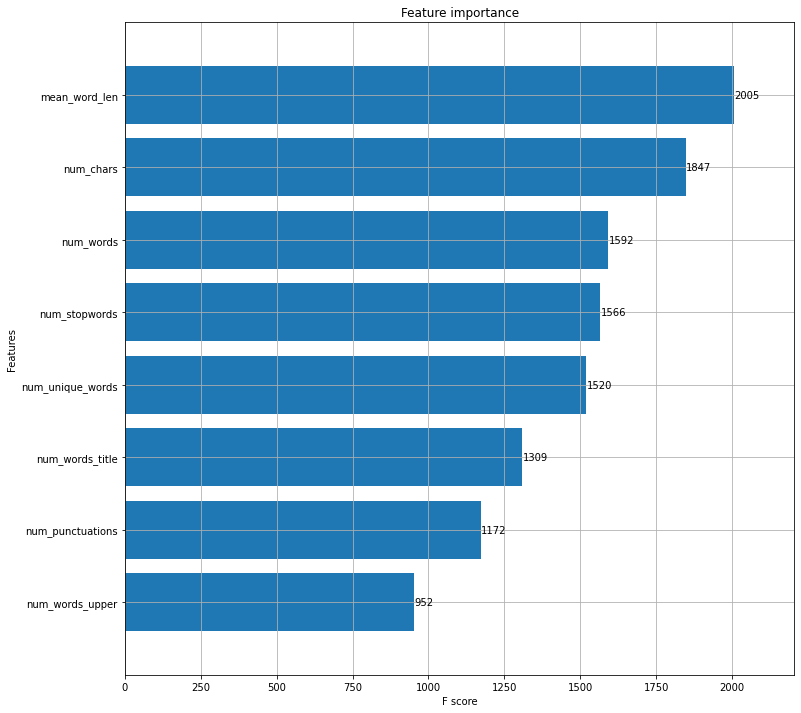

In [24]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

단어의 평균 길이, 문자의 개수, 단어의 개수가 중요도 탑 3 variables입니다.

이제 test based features를 만들어 보겠습니다.

### Text Based Features:
가장 기본적인 feature중 하나는 텍스트에 있는 단어의 tf-idf 값입니다. 그럼 만들어보겠습니다.

In [26]:
# Fit transform the tfidf vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

위 과정을 통해 tfidf 벡터를 얻었고, tricky part가 있습니다.(꼼수?)

tfidf output은 sparse matrix이고, 다른 dense features와 사용 해야할 때 몇가지 선택사항이 있습니다.
1. tfidf vectorizer로부터 top 'n' feature를 고르고, dense format으로 변환한 다음 다른 feature에 이어 붙이는 방법.
2. sparse feature만 이용하여 모델을 하나 만들고, 그 모델로 한 예측을 다른 dense features와 함께 features중 하나로 사용하는 방법
데이터에 따라서 더 잘 어울리는 방법이 달라집니다.

우리는 여기서 2번 째 방법을 사용하겠습니다. 왜냐하면 tfidf의 모든 features를 사용하여 좋은 점수를 얻은 커널이 있기 때문입니다.

또한, Naive Bayes가 이 데이터셋에 더 잘 어울리는 것 같습니다.

따라서 tfidf features를 사용한 naive bayes모델을 훈련 전에 먼저 만들겠습니다.

In [27]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
  model = naive_bayes.MultinomialNB()
  model.fit(train_X, train_y)
  pred_test_y = model.predict_proba(test_X)
  pred_test_y2 = model.predict_proba(test_X2)
  return pred_test_y, pred_test_y2, model

### Naive Bayes on Word Tfidf Vectorizer

In [28]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
  dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
  dev_y, val_y = train_y[dev_index], train_y[val_index]
  pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
  pred_full_test = pred_full_test + pred_test_y
  pred_train[val_index, :] = pred_val_y
  cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.0

Mean cv score :  0.8422161983612855


0.842의 mlogloss를 얻었습니다. metafeature에 비해 더 좋은것을 알 수 있습니다.

confusion matrix를 한 번 확인해보겠습니다.

In [30]:
# Function to create confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

  '''
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  '''

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center',
             color = 'white' if cm[i, j] > thresh else 'black')
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

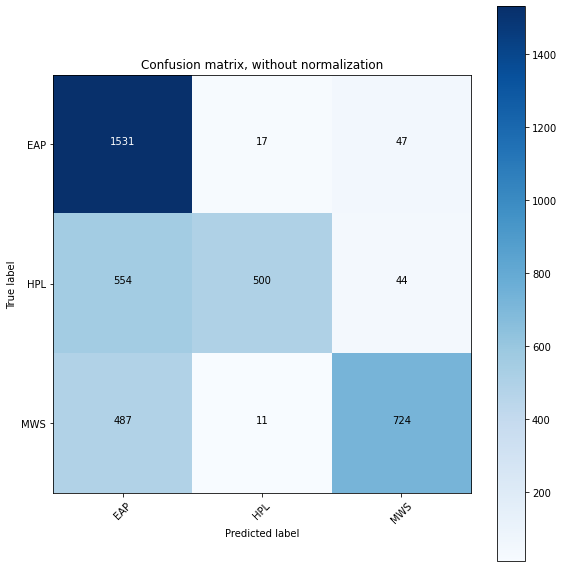

In [31]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

예측이 EAP에 너무 편향되어 있습니다.

### SVD on word TFIDF

tfidf 벡터는 sparse하기 때문에, 정보를 압축하고 더 compact한 방법으로 정보를 표현하는 또 다른 방법은 SVD를 통한 방법이 있습니다.

일반적인 SVD features는 텍스트 기반의 예전 대회에서도 좋은 성능을 보였습니다.

그래서 우리는 svd features를 word tfidf를 이용해서 만들고 우리의 feature set에 추가해주겠습니다.

In [32]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm = 'arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

### Naive Bayes on Word Count Vectorizer

In [33]:
# Fit transform the count vectorizer
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Multinomial NB 모델을 count vectorizer 기반 features를 이용해 만들어 주겠습니다.


In [34]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits = 5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
  dev_X, val_X  = train_tfidf[dev_index], train_tfidf[val_index]
  dev_y, val_y = train_y[dev_index], train_y[val_index]
  pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
  pred_full_test = pred_full_test + pred_test_y
  pred_train[val_index, :] = pred_val_y
  cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


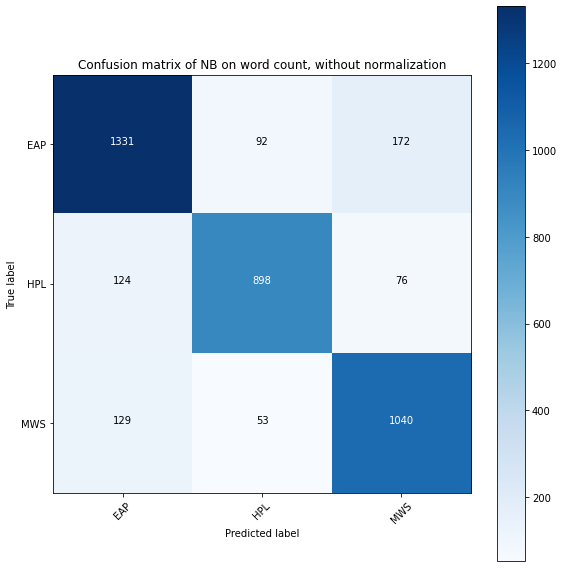

In [35]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

tfidf vectorizer 대신에 count vectorizer를 사용했더니 mlogloss가 0.451까지 감소했습니다.

### Naive Bayes on Character Count Vectorizer

'Data eyeballing'(데이터를 살펴보는?) 아이디어 중 하나는 특별한 문자의 개수를 세는것이 도움을 준다는 것입니다.

특별한 문자의 개수를 세는 것 대신에, 우리는 문자 수준에서 count vectorizer를 사용하여 몇 개의 feature를 만들 수 있습니다. 바로 위에서 사용한 Multinomial NB를 다시 실행해보겠습니다.


In [36]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


cross val score가 아주 높은 3.75가 나왔다. 하지만 이것은 단어 수준의 feature와는 몇몇 다른 정보를 더했기 때문이라 생각했고, 최종 모델에서 사용할 예정이다.

Naive Bayes on Charactoer Tfidf Vectorizer

character tfidf vectorizer를 예측에 이용해보자!

In [37]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


### SVD on Character TFIDF

character tfidf feature를 이용해서도 svd features를 만들고 모델링에 사용할 수 있다.

In [38]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

### XGBoost model

In [40]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00264	test-mlogloss:1.00252
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.411212	test-mlogloss:0.416123
[40]	train-mlogloss:0.340595	test-mlogloss:0.353123
[60]	train-mlogloss:0.317139	test-mlogloss:0.336646
[80]	train-mlogloss:0.300647	test-mlogloss:0.327143
[100]	train-mlogloss:0.287084	test-mlogloss:0.320742
[120]	train-mlogloss:0.27591	test-mlogloss:0.316093
[140]	train-mlogloss:0.265819	test-mlogloss:0.313793
[160]	train-mlogloss:0.257669	test-mlogloss:0.312049
[180]	train-mlogloss:0.249599	test-mlogloss:0.310796
[200]	train-mlogloss:0.242103	test-mlogloss:0.309073
[220]	train-mlogloss:0.235175	test-mlogloss:0.307382
[240]	train-mlogloss:0.22828	test-mlogloss:0.306606
[260]	train-mlogloss:0.222457	test-mlogloss:0.306277
[280]	train-mlogloss:0.216763	test-mlogloss:0.306058
[300]	train-mlogloss:0.210979	test-mlogloss:0.306156
[320]	train

feature importance를 확인 해보겠습니다.

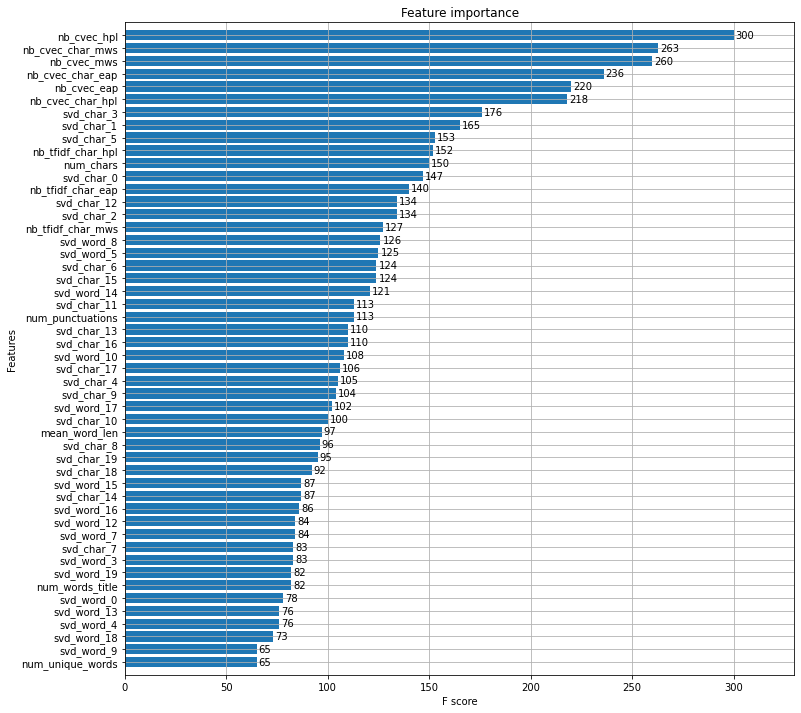

In [41]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

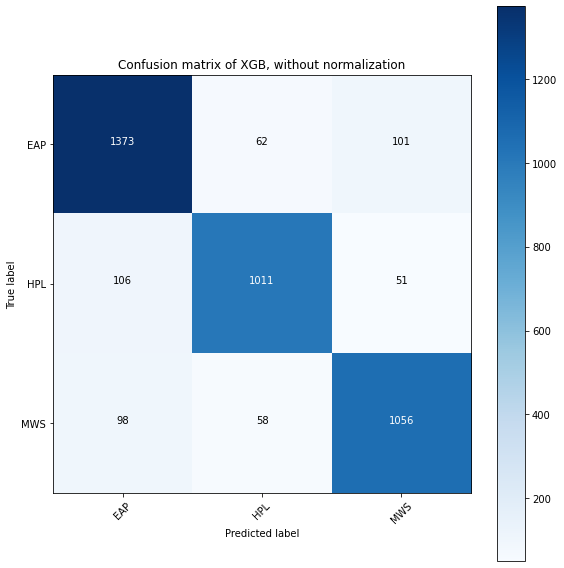

In [42]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()